In [357]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [358]:
trainDF = pd.read_csv('train.csv')
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [359]:
testDF = pd.read_csv('test.csv')
testDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [360]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, DF):
        if 'label' in DF.columns:
            self.x = DF.drop(columns=['label']).values
            self.y = pd.get_dummies(DF['label']).values
        else:
            self.x = DF.values
        pass

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x=torch.FloatTensor(self.x[idx].reshape(1,28,28))

        if hasattr(self,'y'):
            y=torch.FloatTensor(self.y[idx])
            return x,y
        else:
            return x

trainSet= MyDataset(DF=trainDF)
testSet= MyDataset(DF=testDF)
trainSet[0][1]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [361]:
class MySampler(torch.utils.data.sampler.Sampler):
    def __init__(self, indices):
        self.indices = indices
        
    def __iter__(self):
        return iter(self.indices)

dataset_size = len(trainSet)
indices = list(range(dataset_size))
split = int(0.2* dataset_size)
train_indices, val_indices = indices[split:], indices[:split]

trainSampler= MySampler(train_indices)
valSampler= MySampler(val_indices)
# val_indices

In [362]:
trainLoader= torch.utils.data.DataLoader(trainSet,batch_size=2048,sampler=trainSampler)
valLoader= torch.utils.data.DataLoader(trainSet,batch_size=2048,sampler=valSampler)
testLoader = torch.utils.data.DataLoader(testSet)
trainLoader

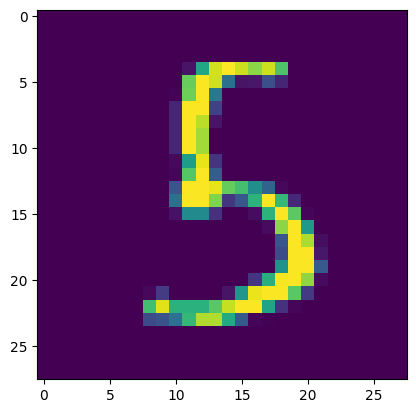

In [363]:
# get some random training images
dataiter = iter(trainLoader)
images, labels = next(dataiter)

# show images
plt.imshow(images[0][0])

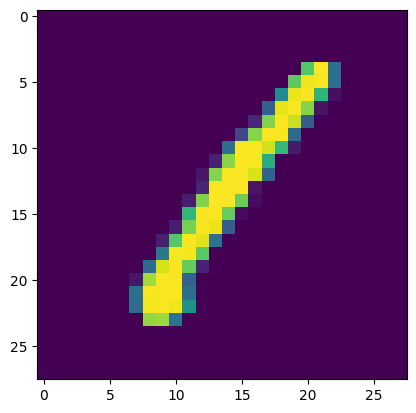

In [364]:
# get some random training images
dataiter = iter(valLoader)
images, labels = next(dataiter)

# show images
plt.imshow(images[0][0])

In [365]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convStack = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, 3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Conv2d(1, 1, 3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Flatten(),
            torch.nn.Linear(25, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 10),
        )

    def forward(self, x):
        logits = self.convStack(x)
        return logits


net = Net()

model = Net().to(device)
print(model)

Using mps device
Net(
  (convStack): Sequential(
    (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=25, out_features=18, bias=True)
    (8): ReLU()
    (9): Linear(in_features=18, out_features=10, bias=True)
  )
)


In [366]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters())

In [367]:
def trainAI(dataloader, model, loss_fn, optimizer):
    model.train()
    trainLoss=0
    for  X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        trainLoss +=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return trainLoss

In [368]:
def valAI(dataLoader, model, loss_fn,):
    model.eval()
    valLoss=0
    with torch.no_grad():
        for X,y in dataLoader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            valLoss+=loss.item()
    
    return valLoss

In [369]:
trainHistory,valHistory,=[],[]
bestLoss= float('inf')
cnt = 0
bestModel= model
while(cnt<100):
    trainLoss = trainAI(trainLoader, model, loss_fn, optimizer)
    valLoss = valAI(valLoader, model, loss_fn)

    trainHistory.append(trainLoss)
    valHistory.append(valLoss)

    print(f'loss: {bestLoss-valLoss}')

    if bestLoss<valLoss:
        cnt+=1
    else:
        bestLoss = valLoss
        bestModel= model 

plt.plot(trainHistory,label='train')
plt.plot(valHistory, label='val')
plt.legend()

loss: inf
loss: 0.6499006748199463
loss: 0.25020933151245117
loss: 0.1301734447479248
loss: 0.06680703163146973
loss: 0.03271746635437012
loss: 0.015613079071044922
loss: 0.008515596389770508
loss: 0.0050504207611083984
loss: 0.0029909610748291016
loss: 0.0020322799682617188
loss: 0.0018014907836914062
loss: 0.0012483596801757812
loss: 0.0008413791656494141
loss: 0.0006580352783203125
loss: 0.0005822181701660156
loss: 0.0006518363952636719
loss: 0.0006773471832275391
loss: 0.0007002353668212891
loss: 0.0006792545318603516
loss: 0.0007047653198242188
loss: 0.0007216930389404297
loss: 0.0008246898651123047
loss: 0.0008215904235839844
loss: 0.0008051395416259766
loss: 0.0008409023284912109
loss: 0.0008776187896728516
loss: 0.0009088516235351562
loss: 0.0008931159973144531
loss: 0.0008990764617919922
loss: 0.0009458065032958984
loss: 0.0009458065032958984
loss: 0.0009610652923583984
loss: 0.0010650157928466797
loss: 0.0010647773742675781
loss: 0.0009899139404296875
loss: 0.0010304450988769

KeyboardInterrupt: 

In [ ]:
def testAI(dataloader, model):
    model.eval()
    out = []
    y=1
    with torch.no_grad():
        for X in dataloader:
            X  = X.to(device)
            pred = model(X)
            out.append([y, torch.argmax(pred).item()])
            y+=1
    
    return out

result = testAI(testLoader, bestModel)
result

[[1, 2],
 [2, 0],
 [3, 9],
 [4, 6],
 [5, 2],
 [6, 7],
 [7, 0],
 [8, 3],
 [9, 0],
 [10, 3],
 [11, 5],
 [12, 7],
 [13, 3],
 [14, 0],
 [15, 9],
 [16, 5],
 [17, 3],
 [18, 1],
 [19, 9],
 [20, 0],
 [21, 9],
 [22, 1],
 [23, 1],
 [24, 5],
 [25, 7],
 [26, 4],
 [27, 2],
 [28, 7],
 [29, 4],
 [30, 7],
 [31, 7],
 [32, 5],
 [33, 4],
 [34, 2],
 [35, 6],
 [36, 2],
 [37, 5],
 [38, 5],
 [39, 1],
 [40, 6],
 [41, 7],
 [42, 7],
 [43, 4],
 [44, 9],
 [45, 8],
 [46, 7],
 [47, 8],
 [48, 8],
 [49, 6],
 [50, 7],
 [51, 6],
 [52, 8],
 [53, 8],
 [54, 3],
 [55, 8],
 [56, 2],
 [57, 1],
 [58, 2],
 [59, 2],
 [60, 0],
 [61, 4],
 [62, 1],
 [63, 7],
 [64, 0],
 [65, 0],
 [66, 0],
 [67, 1],
 [68, 9],
 [69, 0],
 [70, 1],
 [71, 6],
 [72, 5],
 [73, 8],
 [74, 8],
 [75, 2],
 [76, 3],
 [77, 3],
 [78, 9],
 [79, 2],
 [80, 3],
 [81, 5],
 [82, 4],
 [83, 1],
 [84, 8],
 [85, 9],
 [86, 2],
 [87, 4],
 [88, 3],
 [89, 6],
 [90, 7],
 [91, 2],
 [92, 0],
 [93, 6],
 [94, 6],
 [95, 1],
 [96, 4],
 [97, 3],
 [98, 9],
 [99, 7],
 [100, 7],
 [101, 0

In [ ]:
result = pd.DataFrame(result)
result = result.astype(int)
result.columns=['ImageId','Label']
result

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,6
4,5,2
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [ ]:
result.to_csv('result.csv',index=False)